<a href="https://colab.research.google.com/github/bksgupta/course-v3/blob/master/lesson6_rossmann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.tabular import *

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Rossmann

## Data preparation

To create the feature-engineered train_clean and test_clean from the Kaggle competition data, run `rossman_data_clean.ipynb`. One important step that deals with time series is this:

```python
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)
```

In [4]:
path = Config().data_path()/'rossmann'

In [5]:
path.mkdir(parents=True)

In [6]:
path.ls()

[]

In [7]:
# path = Config().data_path()/'rossmann'
!cp '/content/drive/My Drive/data/rossman_clean/train_clean' {path}
!cp '/content/drive/My Drive/data/rossman_clean/test_clean' {path}
train_df = pd.read_pickle(path/'train_clean')

In [8]:
path.ls()

[PosixPath('/root/.fastai/data/rossmann/test_clean'),
 PosixPath('/root/.fastai/data/rossmann/train_clean')]

In [9]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
...,...,...,...,...,...
StateHoliday_bw,0,0,0,0,0
Promo_bw,5,5,5,5,5
SchoolHoliday_fw,7,1,5,1,1
StateHoliday_fw,0,0,0,0,0


In [10]:
n = len(train_df); n

844338

In [11]:
range(5)

range(0, 5)

### Experimenting with a sample

In [23]:
idx = np.random.permutation(range(n))[:2000]
print (idx.sort())
idx

None


array([   201,    617,    811,   1528, ..., 843158, 843641, 843910, 844016])

In [24]:
idx = np.random.permutation(range(n))[:2000]
idx.sort()
small_train_df = train_df.iloc[idx[:1000]]
small_test_df = train_df.iloc[idx[1000:]]
small_cont_vars = ['CompetitionDistance', 'Mean_Humidity']
small_cat_vars =  ['Store', 'DayOfWeek', 'PromoInterval']
small_train_df = small_train_df[small_cat_vars + small_cont_vars + ['Sales']]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]

In [25]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
180,181,5,"Jan,Apr,Jul,Oct",12610.0,50,8398
1942,831,4,NaN,800.0,73,13681
2250,25,3,NaN,430.0,67,10527
2422,197,3,NaN,4210.0,77,8248
3593,255,2,"Feb,May,Aug,Nov",4630.0,66,7969


In [26]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
414411,328,2,NaN,3130.0,72,3670
415604,407,1,"Feb,May,Aug,Nov",5890.0,76,2889
416489,146,6,"Jan,Apr,Jul,Oct",8050.0,78,6671
416678,335,6,"Jan,Apr,Jul,Oct",90.0,78,9111
416952,609,6,NaN,2070.0,64,3002


In [27]:
categorify = Categorify(small_cat_vars, small_cont_vars)
categorify(small_train_df)
categorify(small_test_df, test=True)

In [28]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
180,181,5,"Jan,Apr,Jul,Oct",12610.0,50,8398
1942,831,4,NaN,800.0,73,13681
2250,25,3,NaN,430.0,67,10527
2422,197,3,NaN,4210.0,77,8248
3593,255,2,"Feb,May,Aug,Nov",4630.0,66,7969


In [29]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
414411,328,2,NaN,3130.0,72,3670
415604,NaN,1,"Feb,May,Aug,Nov",5890.0,76,2889
416489,146,6,"Jan,Apr,Jul,Oct",8050.0,78,6671
416678,NaN,6,"Jan,Apr,Jul,Oct",90.0,78,9111
416952,NaN,6,NaN,2070.0,64,3002


In [30]:
small_train_df.PromoInterval.cat.categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [31]:
small_train_df['PromoInterval'].cat.codes[:5]

180     1
1942   -1
2250   -1
2422   -1
3593    0
dtype: int8

In [36]:
small_train_df[small_train_df['CompetitionDistance'].isnull()== True ]

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
195186,291,5,NaN,NaN,78,8464
391104,622,2,NaN,NaN,63,4603
410503,879,6,"Feb,May,Aug,Nov",NaN,75,3169


In [37]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

In [38]:
small_train_df[small_train_df['CompetitionDistance_na'] == True]

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
195186,291,5,NaN,2180.0,78,8464,True
391104,622,2,NaN,2180.0,63,4603,True
410503,879,6,"Feb,May,Aug,Nov",2180.0,75,3169,True


### Preparing full data set

In [39]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [40]:
len(train_df),len(test_df)

(844338, 41088)

In [41]:
procs=[FillMissing, Categorify, Normalize]

In [42]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [43]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [72]:
len(cont_vars) + len(cat_vars)

38

In [44]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [60]:
train_df.head()

,index,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State,file,week,trend,file_DE,week_DE,trend_DE,Date_DE,...,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,CompetitionOpenSince,CompetitionDaysOpen,CompetitionMonthsOpen,Promo2Since,Promo2Days,Promo2Weeks,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,0,1,5,2015-07-31,5263,555,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,c,a,1270.0,9,2008,0,1,1900,NaN,HE,Rossmann_DE_HE,2015-08-02 - 2015-08-08,85,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,...,16,8,9,6,3,98,54,18,1021,1018,1015,31.0,15.0,10.0,24,11,NaN,0.0,1.0,Fog,13,Hessen,2008-09-15,2510,24,1900-01-01,0,0,0,0,57,0,0,0,5.0,0.0,5.0,7.0,0.0,5.0
1,1,2,5,2015-07-31,6064,625,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",TH,Rossmann_DE_TH,2015-08-02 - 2015-08-08,80,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,...,13,7,9,6,3,100,62,25,1021,1019,1017,10.0,10.0,10.0,14,11,NaN,0.0,4.0,Fog,309,Thueringen,2007-11-15,2815,24,2010-03-29,1950,25,0,0,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
2,2,3,5,2015-07-31,8314,821,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",NW,Rossmann_DE_NW,2015-08-02 - 2015-08-08,86,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,...,13,6,10,7,4,100,61,24,1022,1019,1017,31.0,14.0,10.0,14,5,NaN,0.0,2.0,Fog,354,NordrheinWestfalen,2006-12-15,3150,24,2011-04-04,1579,25,0,0,57,0,0,0,5.0,0.0,5.0,5.0,0.0,5.0
3,3,4,5,2015-07-31,13995,1498,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,c,c,620.0,9,2009,0,1,1900,NaN,BE,Rossmann_DE_BE,2015-08-02 - 2015-08-08,74,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,...,14,9,9,7,4,94,61,30,1019,1017,1014,10.0,10.0,10.0,23,16,NaN,0.0,6.0,NaN,282,Berlin,2009-09-15,2145,24,1900-01-01,0,0,0,0,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
4,4,5,5,2015-07-31,4822,559,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,29910.0,4,2015,0,1,1900,NaN,SN,Rossmann_DE_SN,2015-08-02 - 2015-08-08,82,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,...,15,10,8,6,5,82,55,26,1020,1018,1016,10.0,10.0,10.0,14,11,NaN,0.0,4.0,NaN,290,Sachsen,2015-04-15,107,3,1900-01-01,0,0,0,0,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0


In [46]:
test_df.head()

,index,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State,file,week,trend,file_DE,week_DE,trend_DE,Date_DE,State_DE,...,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,CompetitionOpenSince,CompetitionDaysOpen,CompetitionMonthsOpen,Promo2Since,Promo2Days,Promo2Weeks,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,0,1,1,4,2015-09-17,1.0,1,False,0,2015,9,38,17,3,260,False,False,False,False,False,False,1442448000,c,a,1270.0,9,2008,0,1,1900,NaN,HE,Rossmann_DE_HE,2015-09-20 - 2015-09-26,69,Rossmann_DE,2015-09-20 - 2015-09-26,67,2015-09-20,None,...,14,13,16,14,12,100,95,88,1013,1004,999,31.0,12.0,7.0,29,14,NaN,7.11,6.0,Rain,191,Hessen,2008-09-15,2558,24,1900-01-01,0,0,13,0,105,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
1,1,2,3,4,2015-09-17,1.0,1,False,0,2015,9,38,17,3,260,False,False,False,False,False,False,1442448000,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",NW,Rossmann_DE_NW,2015-09-20 - 2015-09-26,68,Rossmann_DE,2015-09-20 - 2015-09-26,67,2015-09-20,None,...,14,12,14,12,11,100,78,58,1010,1000,993,26.0,12.0,8.0,37,26,53.0,3.05,6.0,Rain,187,NordrheinWestfalen,2006-12-15,3198,24,2011-04-04,1627,25,37,0,105,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
2,2,3,7,4,2015-09-17,1.0,1,False,0,2015,9,38,17,3,260,False,False,False,False,False,False,1442448000,a,c,24000.0,4,2013,0,1,1900,NaN,SH,Rossmann_DE_SH,2015-09-20 - 2015-09-26,59,Rossmann_DE,2015-09-20 - 2015-09-26,67,2015-09-20,None,...,16,13,16,13,11,96,73,61,1003,998,994,26.0,10.0,2.0,29,14,45.0,0.76,5.0,Rain,209,SchleswigHolstein,2013-04-15,885,24,1900-01-01,0,0,20,0,115,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
3,3,4,8,4,2015-09-17,1.0,1,False,0,2015,9,38,17,3,260,False,False,False,False,False,False,1442448000,a,a,7520.0,10,2014,0,1,1900,NaN,SH,Rossmann_DE_SH,2015-09-20 - 2015-09-26,59,Rossmann_DE,2015-09-20 - 2015-09-26,67,2015-09-20,None,...,16,13,16,13,11,96,73,61,1003,998,994,26.0,10.0,2.0,29,14,45.0,0.76,5.0,Rain,209,SchleswigHolstein,2014-10-15,337,11,1900-01-01,0,0,20,0,115,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
4,4,5,9,4,2015-09-17,1.0,1,False,0,2015,9,38,17,3,260,False,False,False,False,False,False,1442448000,a,c,2030.0,8,2000,0,1,1900,NaN,NW,Rossmann_DE_NW,2015-09-20 - 2015-09-26,68,Rossmann_DE,2015-09-20 - 2015-09-26,67,2015-09-20,None,...,14,12,14,12,11,100,78,58,1010,1000,993,26.0,12.0,8.0,37,26,53.0,3.05,6.0,Rain,187,NordrheinWestfalen,2000-08-15,5511,24,1900-01-01,0,0,37,0,105,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0


In [54]:
test_df.iloc[100]

index                               100
Id                                  101
Store                               135
DayOfWeek                             4
Date                2015-09-17 00:00:00
                           ...         
StateHoliday_bw                       0
Promo_bw                              4
SchoolHoliday_fw                      0
StateHoliday_fw                       0
Promo_fw                              1
Name: 100, Length: 92, dtype: object

In [61]:
train_df['Date'][len(test_df) ]

Timestamp('2015-06-19 00:00:00')

In [62]:
train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])]

40282   2015-06-19
40283   2015-06-19
40284   2015-06-19
40285   2015-06-19
40286   2015-06-19
           ...    
41391   2015-06-19
41392   2015-06-19
41393   2015-06-19
41394   2015-06-19
41395   2015-06-19
Name: Date, Length: 1114, dtype: datetime64[ns]

In [63]:
len(train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])])

1114

In [64]:
len(test_df)

41088

In [65]:
train_df['Date'][len(test_df)]

Timestamp('2015-06-19 00:00:00')

In [66]:
len(train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])])

1114

In [68]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [69]:
valid_idx = range(cut)

In [70]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [71]:
df.head()

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,PromoInterval,CompetitionOpenSinceYear,Promo2SinceYear,State,Week,Events,Promo_fw,Promo_bw,StateHoliday_fw,StateHoliday_bw,SchoolHoliday_fw,SchoolHoliday_bw,CompetitionDistance,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales,Date
0,1,5,2015,7,31,False,24,0,c,a,NaN,2008,1900,HE,31,Fog,5.0,5.0,0.0,0.0,7.0,5.0,1270.0,23,16,8,98,54,18,24,11,1.0,85,83,57,0,1,1,5263,2015-07-31
1,2,5,2015,7,31,False,24,25,a,a,"Jan,Apr,Jul,Oct",2007,2010,TH,31,Fog,1.0,5.0,0.0,0.0,1.0,5.0,570.0,19,13,7,100,62,25,14,11,4.0,80,83,67,0,1,1,6064,2015-07-31
2,3,5,2015,7,31,False,24,25,a,a,"Jan,Apr,Jul,Oct",2006,2011,NW,31,Fog,5.0,5.0,0.0,0.0,5.0,5.0,14130.0,21,13,6,100,61,24,14,5,2.0,86,83,57,0,1,1,8314,2015-07-31
3,4,5,2015,7,31,False,24,0,c,c,NaN,2009,1900,BE,31,NaN,1.0,5.0,0.0,0.0,1.0,5.0,620.0,19,14,9,94,61,30,23,16,6.0,74,83,67,0,1,1,13995,2015-07-31
4,5,5,2015,7,31,False,3,0,a,a,NaN,2015,1900,SN,31,NaN,1.0,5.0,0.0,0.0,1.0,5.0,29910.0,20,15,10,82,55,26,14,11,4.0,82,83,57,0,1,1,4822,2015-07-31


In [73]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

In [ ]:
doc(FloatList)

## Model

In [74]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [75]:
y_range

tensor([ 0.0000, 10.8170], device='cuda:0', dtype=torch.float64)

In [77]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [78]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_runn

In [79]:
len(data.train_ds.cont_names)

16

In [80]:
learn.lr_find()

epoch,train_loss,valid_loss,exp_rmspe,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


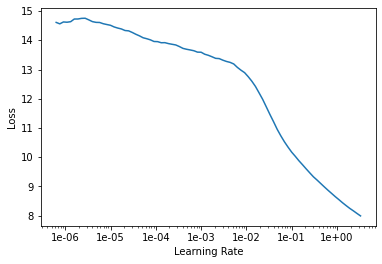

In [81]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

In [ ]:
learn.save('1')

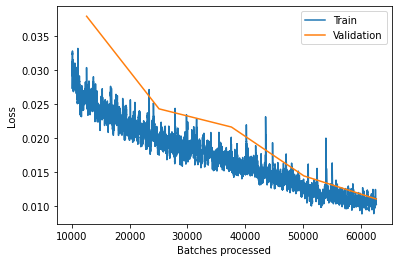

In [ ]:
learn.recorder.plot_losses(skip_start=10000)

In [ ]:
learn.load('1');

In [ ]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.013885,0.012137,0.108950,02:36
1,0.012248,0.023823,0.112141,02:37
2,0.010651,0.015752,0.105781,02:35
3,0.010334,0.034137,0.111870,02:34
4,0.008828,0.013221,0.109129,02:33


In [ ]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.010093,0.016219,0.106680,02:36
1,0.011330,0.015267,0.119531,02:37
2,0.012049,0.025930,0.117909,02:34
3,0.008759,0.012617,0.109421,02:36
4,0.009519,0.017105,0.117857,02:36


(10th place in the competition was 0.108)

In [ ]:
test_preds=learn.get_preds(DatasetType.Test)
test_df["Sales"]=np.exp(test_preds[0].data).numpy().T[0]
test_df[["Id","Sales"]]=test_df[["Id","Sales"]].astype("int")
test_df[["Id","Sales"]].to_csv("rossmann_submission.csv",index=False)